In [2]:
import sklearn
sklearn.__version__

'0.21.3'

In [3]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import statsmodels.api as sm
from typing import List
from scipy.stats import normaltest, stats

In [243]:
seattle_housing = pull_data()

In [6]:
def pull_data(dbname = 'Seattle_housing', low_limit = '200000', high_limit = '2500000', year = 2018):
    """This function takes data from a postgreSQL database and returns a target dataframe and features dataframe."""
    engine = create_engine(f"postgresql:///{dbname}")
    query = f"""SELECT 
               *
            FROM rpsale rp
            JOIN resbldg rd
            ON CONCAT(rp."Major", rp."Minor") = Concat(rd."Major", rd."Minor")
            JOIN parcel p
            ON CONCAT(rp."Major", rp."Minor") = Concat(p."Major", p."Minor")
            WHERE "SalePrice" > {low_limit} AND "SalePrice" < {high_limit}
            AND SUBSTRING("DocumentDate", 7, 4) = '{year}'
         """
    seattle_housing = pd.read_sql(sql = query, con = engine)
    return seattle_housing

In [7]:
def build_base(seattle_housing, target = 'SalePrice', basefeatures = ["SqFtTotLiving", "WfntLocation", "SqFtOpenPorch", "SqFtEnclosedPorch", "TrafficNoise", "PowerLines", "OtherNuisances"]):    
    """This function builds the DataFrames that will be used to make the base model from the housing database."""
    
    dep_var = seattle_housing[[target]]
    
    features = pd.DataFrame()
    for feature in basefeatures:
        features = pd.concat([features, seattle_housing[feature]], axis = 1)
    if ("SqFtOpenPorch" in features.columns) and ("SqFtEnclosedPorch" in features.columns):
        features['Porch'] = features['SqFtOpenPorch'] + features['SqFtEnclosedPorch']
        for i, row in features.iterrows():
            if row['Porch'] > 0:
                row['Porch'] = 1
            else:
                row['Porch'] = 0
        features = features.drop(["SqFtOpenPorch", "SqFtEnclosedPorch"], axis = 1)
    else:
        next
    if "WfntLocation" in features.columns:
        for i, row in features.iterrows():
            if row['WfntLocation'] > 0:
                row['WfntLocation'] = 1
            else:
                row['WfntLocation'] = 0
    else:
        next
    
    
    def clean_noise(row: pd.DataFrame) -> int:
        if (row['TrafficNoise'] > 0) or (row['PowerLines'] == 'Y') or (row['OtherNuisances'] == 'Y'):
            return 1
        else:
            return 0
        
    features['Noise'] = features.apply(clean_noise, axis=1)
    features = features.drop(["TrafficNoise", "PowerLines", "OtherNuisances"], axis = 1)
    
    return dep_var, features

In [8]:
def load_con(input_df: pd.DataFrame, con_var: List[str]) -> pd.DataFrame:
    """Loads continuous variables"""
    # Load necessary data
    con_df = input_df[con_var]
    return con_df

In [9]:
def make_ohe(input_df: pd.DataFrame, cat_var: List[str]) -> pd.DataFrame:
    """One Hot Encodes categorical variables"""
    # Load necessary data
    cat_df = input_df[cat_var]
    # Create OHE object
    ohe = OneHotEncoder(categories = 'auto', drop = 'first').fit(cat_df)
    # Create OHE DataFrame
    ohe_df = pd.DataFrame(ohe.transform(cat_df).toarray(), 
                          columns=ohe.get_feature_names(cat_var))
    return ohe_df

In [10]:
def combine(base: pd.DataFrame, cont: pd.DataFrame, cat: pd.DataFrame) -> pd.DataFrame:
    """Combines all three DataFrames"""
    return pd.concat([base, cont, cat], axis = 1)

In [11]:
def model_eval(model, dep_var, big_df):
    """Builds an OLS linear regression model based on target and features, returns a statsmodel summary, residual 
    plot, Q-Q plot, normality test result, correlation matrix plot for the features, and test for homoskedasticity."""
    
    residuals = model.resid
    plt.style.use('seaborn-notebook')
    fig, axes = plt.subplots(2, 2, figsize = (10, 10))
    sm.qqplot(residuals, ax=axes[(0, 0)], line='s')
    axes[(0,0)].set_title('Q-Q Plot')
    sns.residplot(dep_var, residuals, ax=axes[(0, 1)])
    axes[(0,1)].set_title(f'{normaltest(residuals)}')
    axes[(0,1)].set_xlabel('Predicted')
    axes[(0,1)].set_ylabel('Residuals')
    sns.distplot(residuals, ax=axes[(1, 0)])
    axes[(1, 0)].set_title('Distribution of Residuals')
    sns.heatmap(big_df.corr(), ax = axes[(1,1)])
    axes[(1,1)].set_title('Features Correlation Matrix')    


In [12]:
def ols(dep_var, big_df):
    ss = StandardScaler()
    scaled_features = pd.DataFrame(ss.fit_transform(big_df), columns = big_df.columns)
    model = sm.OLS(dep_var, sm.add_constant(scaled_features)).fit()
    return model

In [13]:
def drop_features(model, big_df):
    lost_p = []
    lost_cor = []
    for i, p in enumerate(model.pvalues):
        if p > 0.05:
            lost_p.append(model.params.index[i])
            #big_df = big_df.drop(model.params.index[i], axis = 1)
            
    # Create correlation matrix
    corr_matrix = big_df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
    # Drop features 
    big_df = big_df.drop(big_df[to_drop], axis=1)      
            
    edited_df = big_df
    print("Features with p-values greater than 0.05: ")
    print(lost_p)
    print(len(lost_p))
    
    print("""
          
          Lost Features from corellation: """)
    print(to_drop)
    print(len(to_drop))
    
    return edited_df

In [14]:
def coef(model):
    #order = model.params.abs().sort_values(ascending = False)
    order = model.params.sort_values(ascending = False)
    
    return order


In [71]:
def base_model():
    print("base model summary")
    seattle_housing = pull_data()
    dep_var, features = build_base(seattle_housing)
    base_model = ols(dep_var, features)
    model_eval(base_model, dep_var, features)
    return base_model, dep_var, features

In [16]:
def model(con_var: List[str], cat_var: List[str]) -> None:
    """makes model, gets report, display stats"""
    seattle_housing = pull_data()
    dep_var, features = build_base(seattle_housing)
    
    cont = load_con(seattle_housing, con_var)
    cat = make_ohe(seattle_housing, cat_var)
    big_df = combine(features, cont, cat)
    
    print("updated model summary")
    result = ols(dep_var, big_df)
    edited_df = drop_features(result, big_df)
    result_limited = ols(dep_var, edited_df)
    model_eval(result_limited, dep_var, edited_df)
    
    print(coef(result_limited))
    
    return result_limited, dep_var, edited_df


updated model summary
Features with p-values greater than 0.05: 
['SqFtDeck', 'SqFtTotBasement', 'SqFtGarageAttached', 'NbrLivingUnits', 'SqFtEnclosedPorch', 'WfntFootage', 'BrickStone', 'FpSingleStory', 'FpMultiStory', 'FpAdditional', 'Area_100', 'Area_16 ', 'Area_2  ', 'Area_21 ', 'Area_27 ', 'Area_3  ', 'Area_36 ', 'Area_4  ', 'Area_41 ', 'Area_48 ', 'Area_66 ', 'Area_67 ', 'Area_69 ', 'Area_71 ', 'Area_72 ', 'Area_75 ', 'Area_79 ', 'Area_80 ', 'Area_85 ', 'Area_90 ', 'Area_91 ', 'Area_94 ', 'InadequateParking_1.0', 'BldgGrade_4.0', 'BldgGrade_5.0', 'BldgGrade_6.0', 'BldgGrade_7.0', 'BldgGrade_8.0', 'BldgGrade_9.0', 'BldgGrade_10.0', 'BldgGrade_11.0', 'BldgGrade_12.0', 'SaleReason_1.0', 'SaleReason_4.0', 'SaleReason_5.0', 'SaleReason_6.0', 'SaleReason_8.0', 'SaleReason_9.0', 'SaleReason_10.0', 'SaleReason_12.0', 'SaleReason_13.0', 'SaleReason_16.0', 'SaleReason_18.0', 'PropertyType_4.0', 'PropertyType_21.0', 'PropertyType_24.0', 'PropertyType_59.0', 'PrincipalUse_6.0', 'PrincipalUse

/Users/flatironschool/opt/anaconda3/envs/linreg-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


const                 752010.870293
HeatSource_2.0        594597.764306
HeatSource_3.0        511751.232934
HeatSource_1.0        377506.042888
SqFtTotLiving         101833.182642
Condition_4.0          62056.350295
Condition_3.0          57206.438074
Condition_5.0          53759.114071
HeatSource_5.0         51768.493150
BldgGrade_10.0         50770.041902
Area_34                46521.520399
HeatSource_7.0         45232.735032
BldgGrade_9.0          43967.692996
Area_33                43635.390074
BldgGrade_11.0         41253.292145
HeatSource_6.0         39843.118004
Area_46                38648.887179
Area_43                37593.054598
Area_92                33654.460742
Area_13                30397.796590
Area_11                29558.962154
LevyCode_0330          29015.673324
Area_12                28960.451251
Area_14                28334.374433
SqFtLot                26660.155657
Area_82                26531.060436
Area_42                25846.433029
Area_45                25716

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     162.9
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        13:18:48   Log-Likelihood:            -3.8518e+05
No. Observations:               28441   AIC:                         7.716e+05
Df Residuals:                   27807   BIC:                         7.769e+05
Df Model:                         633                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     7.52e+05   1105.020    680.541      0.000     7.5e+05    7.54e+05
SqFtTotLiving            1.018e+05   2858.290     35.627      0.000    9.62e+04    1.07e+05
WfntLocation               1.4e+04   2266.643      6.177      0.000    9557.293    1.84e+04
Porch                    1.516e+04   1415.103     10.710      0.000    1.24e+04    1.79e+04
Noise                   -5414.8880   1181.356     -4.584      0.000   -7730.403   -3099.373
SqFtLot                  2.666e+04   1454.388     18.331      0.000    2.38e+04    2.95e+04
YrBuilt                  1.112e+04   2307.467      4.818      0.000    6594.477    1.56e+04
Bedrooms                -4630.9394   1644.217     -2.817      0.005   -7853.687   -1408.192
BathHalfCount            3841.0613   1437.391      2.672      0.008    1023.704    6658.419
Bath3qtrCount            1.751e+04   1684.854     10.394      0.000    1.42e+04    2.08e+04
SqFtDeck                 -487.1159   1117.685     -0.436      0.663   -2677.833    1703.602
BathFullCount            1.229e+04   1969.653      6.240      0.000    8429.113    1.62e+04
SqFtTotBasement          2483.1278   2086.736      1.190      0.234   -1606.977    6573.233
SqFtGarageAttached      -1054.1390   1768.955     -0.596      0.551   -4521.377    2413.099
NbrLivingUnits            792.5131   2850.917      0.278      0.781   -4795.424    6380.450
Stories                  1.306e+04   1831.980      7.131      0.000    9473.392    1.67e+04
SqFtEnclosedPorch       -4821.5308   1223.002     -3.942      0.000   -7218.675   -2424.387
WfntFootage               668.8250   2009.556      0.333      0.739   -3270.003    4607.653
BrickStone               1228.1828   1217.304      1.009      0.313   -1157.793    3614.159
FpSingleStory             841.0668   1597.662      0.526      0.599   -2290.430    3972.564
FpMultiStory            -4175.1573   1769.633     -2.359      0.018   -7643.725    -706.590
FpFreestanding          -4188.7145   1206.547     -3.472      0.001   -6553.607   -1823.822
FpAdditional            -1292.6670   1554.822     -0.831      0.406   -4340.195    1754.861
Area_100                -1.626e+04   3937.347     -4.130      0.000    -2.4e+04   -8544.369
Area_11                  2.956e+04   5178.171      5.708      0.000    1.94e+04    3.97e+04
Area_12                  2.896e+04   5648.586      5.127      0.000    1.79e+04       4e+04
Area_13                   3.04e+04   5340.933      5.691      0.000    1.99e+04    4.09e+04
Area_14                  2.833e+04   3835.210      7.388      0.000    2.08e+04    3.59e+04
Area_15                  1.958e+04   6058.069      3.233      0.001    7710.362    3.15e+04
Area_16                  5005.5579   5316.622      0.941      0.346   -5415.284    1.54e+04
Area_17                 -6987.5892   5245.354  

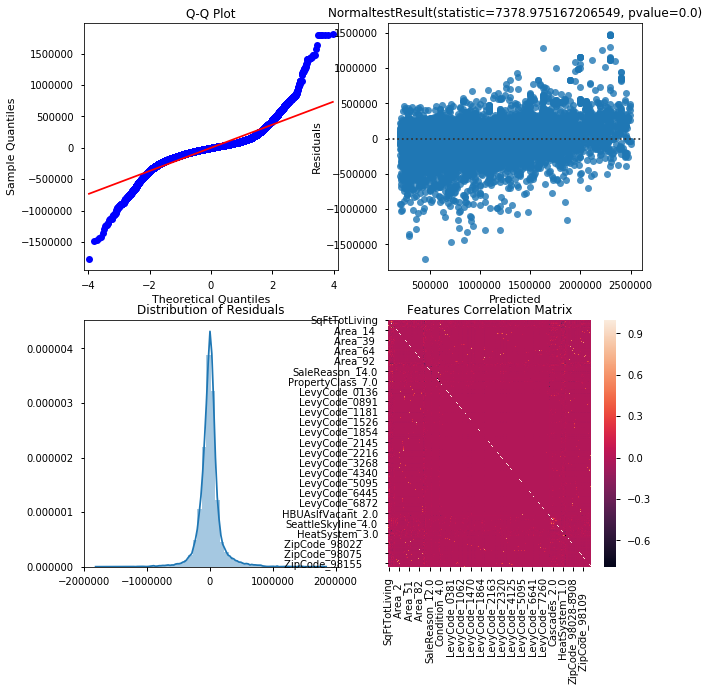

In [247]:
model(con_var = ["SqFtLot", "YrBuilt", "Bedrooms", "BathHalfCount", "Bath3qtrCount", "SqFtDeck",
                "BathFullCount", "SqFtTotBasement", "SqFtGarageAttached", "NbrLivingUnits", "Stories",
                "SqFtOpenPorch", "SqFtEnclosedPorch", "WfntFootage", "BrickStone", "FpSingleStory",
                 "FpMultiStory", "FpFreestanding", "FpAdditional",],
      
      
      cat_var = ["Area","InadequateParking", "BldgGrade", "SaleReason", "PropertyType", "PrincipalUse", 
                 "PropertyClass", "Condition", "PresentUse", "LevyCode", "HBUAsIfVacant", "HBUAsImproved", "MtRainier",
                 "Olympics", "Cascades", "Territorial", "SeattleSkyline", "PugetSound", "LakeWashington", "LakeSammamish",
                 "SmallLakeRiverCreek", "OtherView", "Contamination", "CoalMineHazard", "CriticalDrainage", "ErosionHazard",
                "LandfillBuffer", "HundredYrFloodPlain", "SeismicHazard", "LandslideHazard", "SteepSlopeHazard", "WaterProblems", 
                 "OtherProblems", "PlatType", "DaylightBasement", "HeatSystem", "HeatSource", "ZipCode"])

base model summary


/Users/flatironschool/opt/anaconda3/envs/linreg-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     2972.
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        11:39:04   Log-Likelihood:            -4.4460e+05
No. Observations:               30003   AIC:                         8.892e+05
Df Residuals:                   29998   BIC:                         8.892e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.315e+05   3808.687    218.316      0.000    8.24e+05    8.39e+05
SqFtTotLiving  3.736e+05   4281.084     87.261      0.000    3.65e+05    3.82e+05
WfntLocation   1.082e+05   3818.378     28.346      0.000    1.01e+05    1.16e+05
Porch          4.293e+04   4264.542     10.067      0.000    3.46e+04    5.13e+04
Noise          2.556e+04   3821.370      6.690      0.000    1.81e+04    3.31e+04
==============================================================================
Omnibus:                    40017.351   Durbin-Watson:                   0.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20549793.714
Skew:                           7.278   Prob(JB):                         0.00
Kurtosis:                     130.382   Cond. No.                         1.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

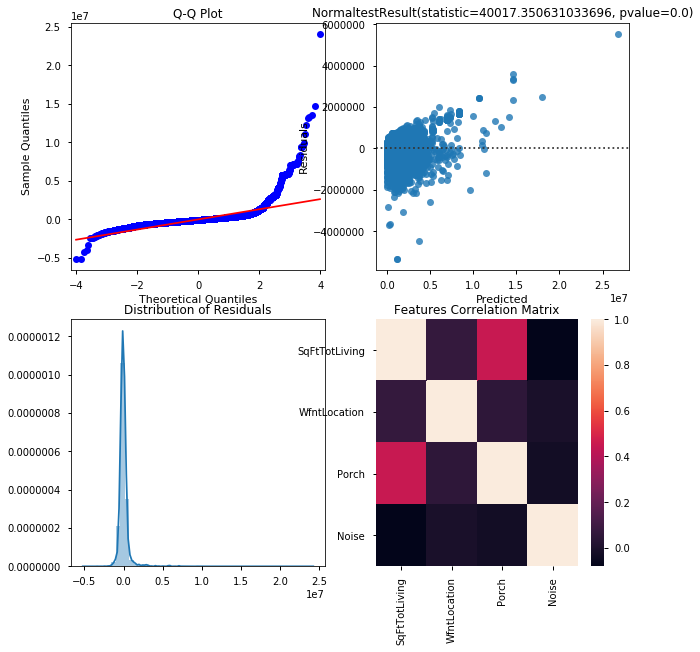

In [207]:
base_model()

## To Do
#### clean up graphs
#### comment code
#### answer these questions
    "How did you pick the question(s) that you did?"
    "Why are these questions important from a business perspective?"
    "How did you decide on the data cleaning options you performed?"
    "Why did you choose a given method or library?"
    "Why did you select those visualizations and what did you learn from each of them?"
    "Why did you pick those features as predictors?"
    "How would you interpret the results?"
    "How confident are you in the predictive quality of the results?"
    "What are some of the things that could cause the results to be wrong?"
#### Jupyter Notebook
#### PowerPoint
#### ReadMe
#### edit yml file

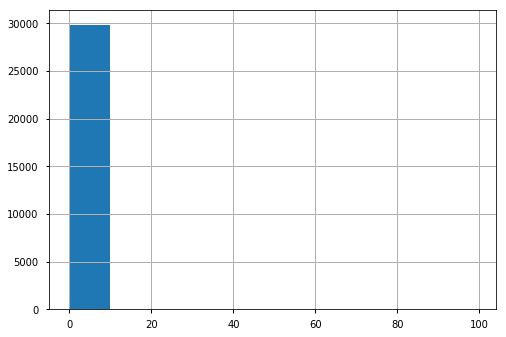

In [186]:
seattle_housing['SqFtTotBasement'].describe()
seattle_housing['Pe'].hist()

In [229]:
seattle_housing['SalePrice'].describe()

count    2.996800e+04
mean     8.324578e+05
std      7.794599e+05
min      1.055000e+04
25%      4.500000e+05
50%      6.650000e+05
75%      9.425000e+05
max      2.675000e+07
Name: SalePrice, dtype: float64

## Nice Graphs

updated model summary
Features with p-values greater than 0.05: 
['SqFtDeck', 'SqFtTotBasement', 'SqFtGarageAttached', 'NbrLivingUnits', 'SqFtEnclosedPorch', 'WfntFootage', 'BrickStone', 'FpSingleStory', 'FpMultiStory', 'FpAdditional', 'Area_100', 'Area_16 ', 'Area_2  ', 'Area_21 ', 'Area_27 ', 'Area_3  ', 'Area_36 ', 'Area_4  ', 'Area_41 ', 'Area_48 ', 'Area_66 ', 'Area_67 ', 'Area_69 ', 'Area_71 ', 'Area_72 ', 'Area_75 ', 'Area_79 ', 'Area_80 ', 'Area_85 ', 'Area_90 ', 'Area_91 ', 'Area_94 ', 'InadequateParking_1.0', 'BldgGrade_4.0', 'BldgGrade_5.0', 'BldgGrade_6.0', 'BldgGrade_7.0', 'BldgGrade_8.0', 'BldgGrade_9.0', 'BldgGrade_10.0', 'BldgGrade_11.0', 'BldgGrade_12.0', 'SaleReason_1.0', 'SaleReason_4.0', 'SaleReason_5.0', 'SaleReason_6.0', 'SaleReason_8.0', 'SaleReason_9.0', 'SaleReason_10.0', 'SaleReason_12.0', 'SaleReason_13.0', 'SaleReason_16.0', 'SaleReason_18.0', 'PropertyType_4.0', 'PropertyType_21.0', 'PropertyType_24.0', 'PropertyType_59.0', 'PrincipalUse_6.0', 'PrincipalUse

/opt/anaconda3/envs/linreg-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


const                 752010.870293
HeatSource_2.0        594597.764306
HeatSource_3.0        511751.232934
HeatSource_1.0        377506.042888
SqFtTotLiving         101833.182642
Condition_4.0          62056.350295
Condition_3.0          57206.438074
Condition_5.0          53759.114071
HeatSource_5.0         51768.493150
BldgGrade_10.0         50770.041902
Area_34                46521.520399
HeatSource_7.0         45232.735032
BldgGrade_9.0          43967.692996
Area_33                43635.390074
BldgGrade_11.0         41253.292145
HeatSource_6.0         39843.118004
Area_46                38648.887179
Area_43                37593.054598
Area_92                33654.460742
Area_13                30397.796590
Area_11                29558.962154
LevyCode_0330          29015.673324
Area_12                28960.451251
Area_14                28334.374433
SqFtLot                26660.155657
Area_82                26531.060436
Area_42                25846.433029
Area_45                25716

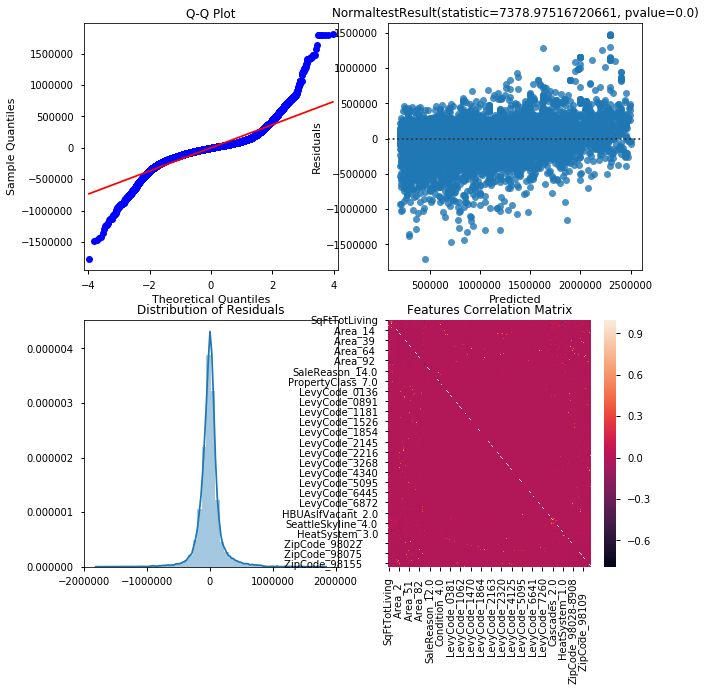

In [17]:
model, dep_var, features = model(con_var = ["SqFtLot", "YrBuilt", "Bedrooms", "BathHalfCount", "Bath3qtrCount", 
                                            "SqFtDeck", "BathFullCount", "SqFtTotBasement", "SqFtGarageAttached", 
                                            "NbrLivingUnits", "Stories", "SqFtOpenPorch", "SqFtEnclosedPorch", 
                                            "WfntFootage", "BrickStone", "FpSingleStory", "FpMultiStory", 
                                            "FpFreestanding", "FpAdditional",], 
                                 cat_var = ["Area","InadequateParking", "BldgGrade", "SaleReason", "PropertyType", 
                                            "PrincipalUse", "PropertyClass", "Condition", "PresentUse", "LevyCode", 
                                            "HBUAsIfVacant", "HBUAsImproved", "MtRainier", "Olympics", "Cascades", 
                                            "Territorial", "SeattleSkyline", "PugetSound", "LakeWashington", 
                                            "LakeSammamish", "SmallLakeRiverCreek", "OtherView", "Contamination", 
                                            "CoalMineHazard", "CriticalDrainage", "ErosionHazard", "LandfillBuffer", 
                                            "HundredYrFloodPlain", "SeismicHazard", "LandslideHazard", 
                                            "SteepSlopeHazard", "WaterProblems", "OtherProblems", "PlatType", 
                                            "DaylightBasement", "HeatSystem", "HeatSource", "ZipCode"])

In [19]:
coefs = coef(model)

In [98]:
tempdf1 = model.pvalues.to_frame(name = 'pvalues')
tempdf2 = model.params.to_frame(name= 'coef')

In [116]:
outputdf = pd.merge(tempdf1, tempdf2, left_index = True, right_index = True)
outputdf.sort_values('coef', ascending=False).head(n=20)

,pvalues,coef
const,0.000000e+00,752010.870293
HeatSource_2.0,3.763814e-11,594597.764306
HeatSource_3.0,6.419539e-11,511751.232934
HeatSource_1.0,5.703186e-11,377506.042888
SqFtTotLiving,6.902532e-272,101833.182642
Condition_4.0,1.791800e-05,62056.350295
Condition_3.0,4.341822e-04,57206.438074
Condition_5.0,6.417925e-07,53759.114071
HeatSource_5.0,2.222952e-11,51768.493150
BldgGrade_10.0,7.930227e-02,50770.041902


In [121]:
outputdf.loc['Noise', :]

pvalues       0.000005
coef      -5414.888010
Name: Noise, dtype: float64

In [28]:
residuals = model.resid
plt.style.use('seaborn-notebook')

In [75]:
def qqplot(model, save = False, filename = "qq_plot.png"):
    """Makes Q-Q Plot from statsmodel OLS model."""
    fig, ax = plt.subplots(figsize = (5, 5), dpi = 150)
    sm.qqplot(model.resid, ax = ax, line = 's')
    ax.set_title('Q-Q Plot of Model')
    fig.tight_layout()
    if save == True:
        fig.savefig(filename, dpi = 300)

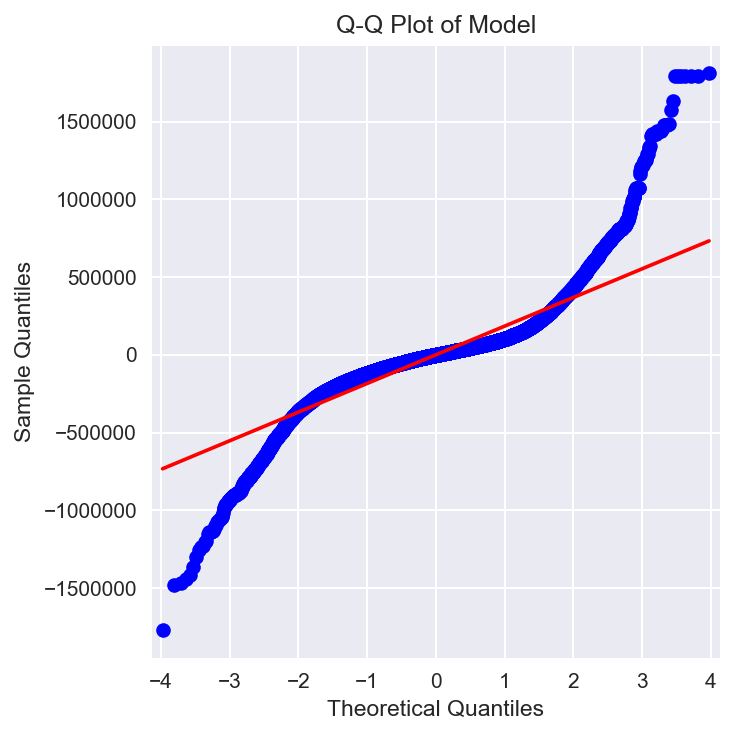

In [57]:
fig, ax = plt.subplots(figsize = (5, 5), dpi = 150)
plt.style.use('seaborn')
sm.qqplot(residuals, ax = ax, line = 's')
ax.set_title('Q-Q Plot of Model')
fig.tight_layout()
fig.savefig('fullmodel_qqplot.png', dpi = 300);

In [67]:
def residplot(model, dep_var, save = False, filename = "residual_plot.png"):
    """Makes plot of residuals vs. expected values for a statsmodel OLS model."""
    fig, ax = plt.subplots(figsize = (5,5), dpi = 150)
    sns.residplot(dep_var, model.resid, ax = ax)
    ax.set_title(f'Residual vs. Expected Value \n Normalilty Test: {round(normaltest(model.resid)[0], 2)}, P-Value: {normaltest(model.resid)[1]}')
    ax.set_xlabel('Expected Sale Price')
    ax.set_ylabel('Residual of Sale Price')
    fig.tight_layout()
    if save == True:
        fig.savefig(filename, dpi = 300)

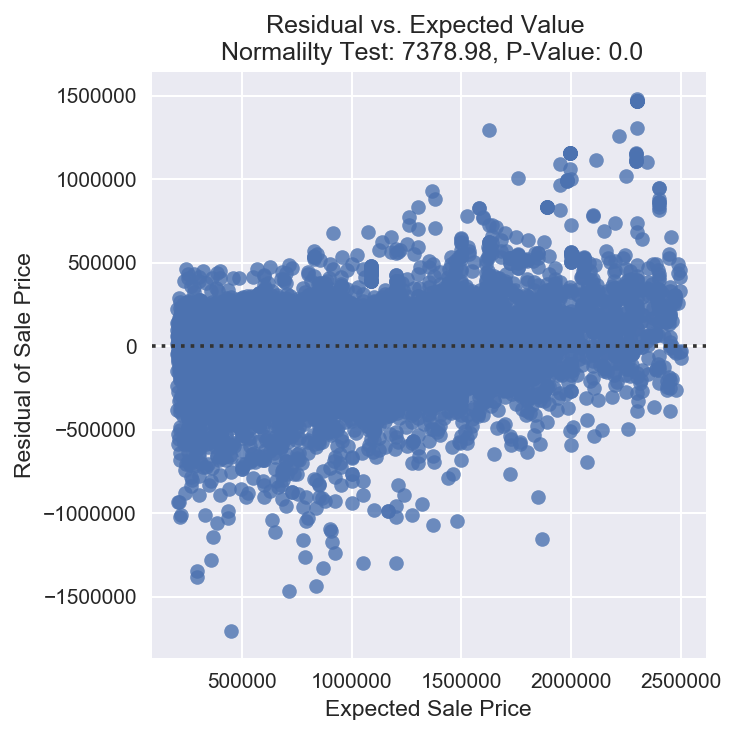

In [54]:
fig, ax = plt.subplots(figsize = (5,5), dpi = 150)
sns.residplot(dep_var, residuals, ax = ax)
ax.set_title(f'Residual vs. Expected Value \n Normalilty Test: {round(normaltest(residuals)[0], 2)}, P-Value: {normaltest(residuals)[1]}')
ax.set_xlabel('Expected Sale Price')
ax.set_ylabel('Residual of Sale Price')
fig.tight_layout()
fig.savefig('fullmodel_residualvsexpected.png', dpi = 300);

In [78]:
def residdistplot(model, save = False, filename = "residual_dist.png"):
    """Makes a distribution plot of residuals from statsmodel OLS model."""
    fig, ax = plt.subplots(figsize = (7,5), dpi = 150)
    sns.distplot(model.resid, ax = ax)
    ax.set_title(f'Distribution of Residuals \n Normalilty Test: {round(normaltest(model.resid)[0], 2)}, P-Value: {normaltest(model.resid)[1]}')
    ax.set_xlabel('Residual of Sale Price')
    ax.set_ylabel('Frequency of Residual')
    fig.tight_layout()
    if save == True:
        fig.savefig(filename, dpi = 300)

/opt/anaconda3/envs/linreg-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


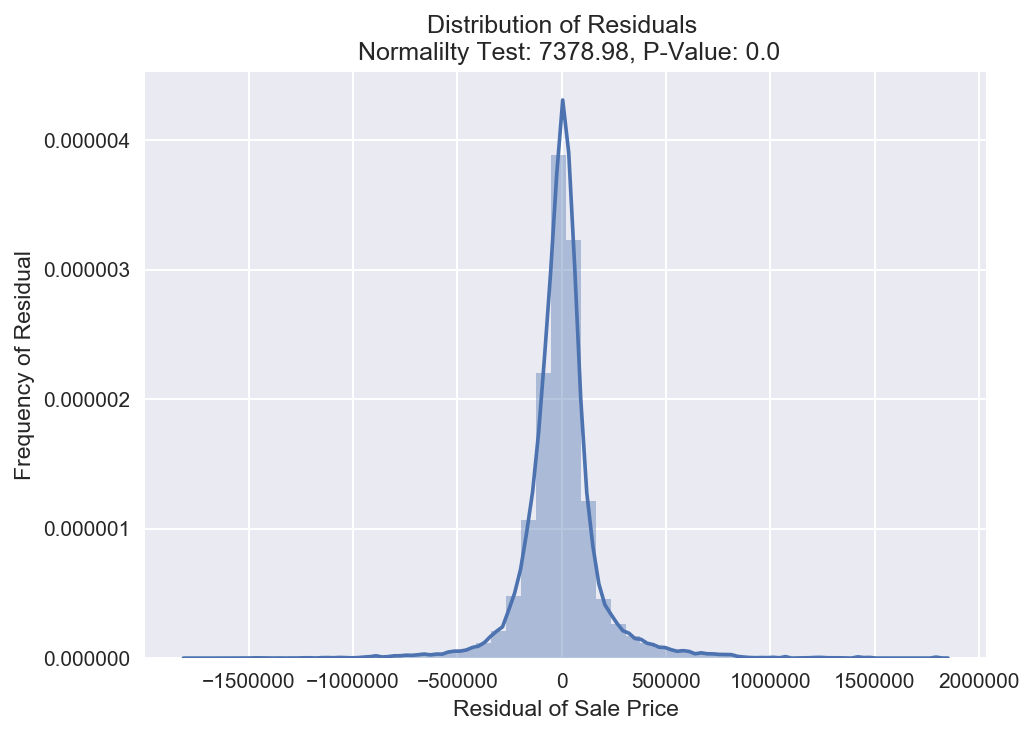

In [55]:
fig, ax = plt.subplots(figsize = (7,5), dpi = 150)
sns.distplot(residuals, ax = ax)
ax.set_title(f'Distribution of Residuals \n Normalilty Test: {round(normaltest(residuals)[0], 2)}, P-Value: {normaltest(residuals)[1]}')
ax.set_xlabel('Residual of Sale Price')
ax.set_ylabel('Frequency of Residual')
fig.tight_layout()
fig.savefig('fullmodel_residualdist.png', dpi = 300);

In [82]:
def corrmatrixplot(features, save = False, filename = "correlation_matrix.png"):
    """Makes a correlation matrix heatmap from a pandas DataFrame of features."""
    fig, ax = plt.subplots(figsize = (5, 5), dpi = 150)
    corr = features.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, ax = ax, cbar = True, xticklabels= False, cmap = 'Blues', yticklabels= False, square = True, mask = mask)
    ax.set_facecolor(color='white')
    ax.set_title('Features Correlation Matrix')
    fig.tight_layout()
    if save == True:
        fig.savefig(filename, dpi = 300)

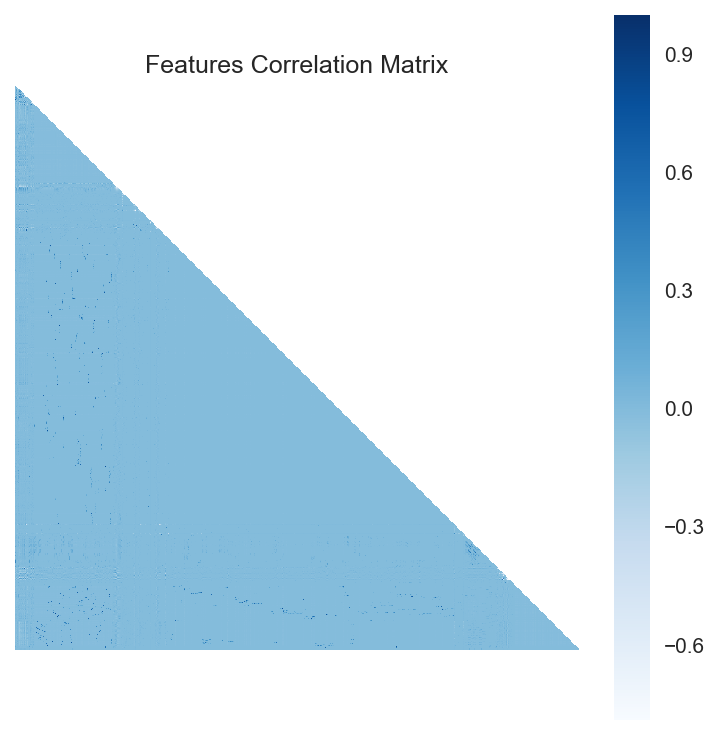

In [81]:
fig, ax = plt.subplots(figsize = (5, 5), dpi = 150)
corr = features.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, ax = ax, cbar = True, xticklabels= False, cmap = 'Blues', yticklabels= False, square = True, mask = mask)
ax.set_title('Features Correlation Matrix')
ax.set_facecolor(color='white')
fig.tight_layout()
fig.savefig('fullmodel_corrmatrix.png', dpi = 300);    

base model summary


/opt/anaconda3/envs/linreg-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


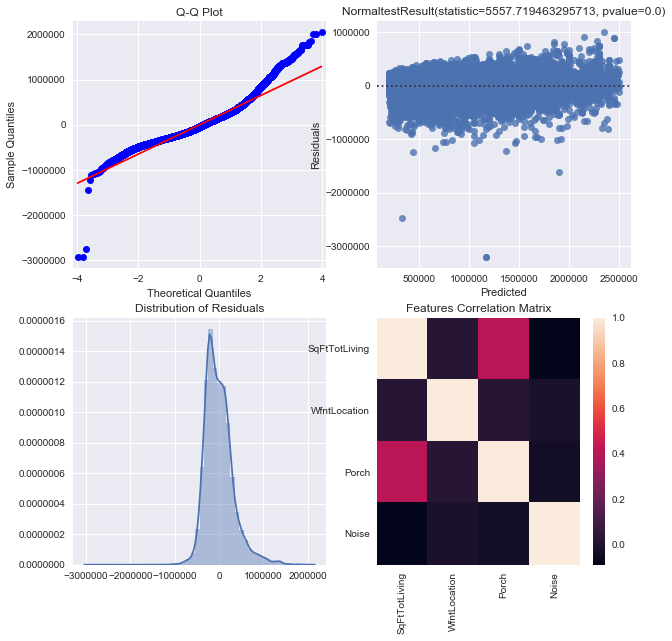

In [72]:
base, base_dep, base_features = base_model()

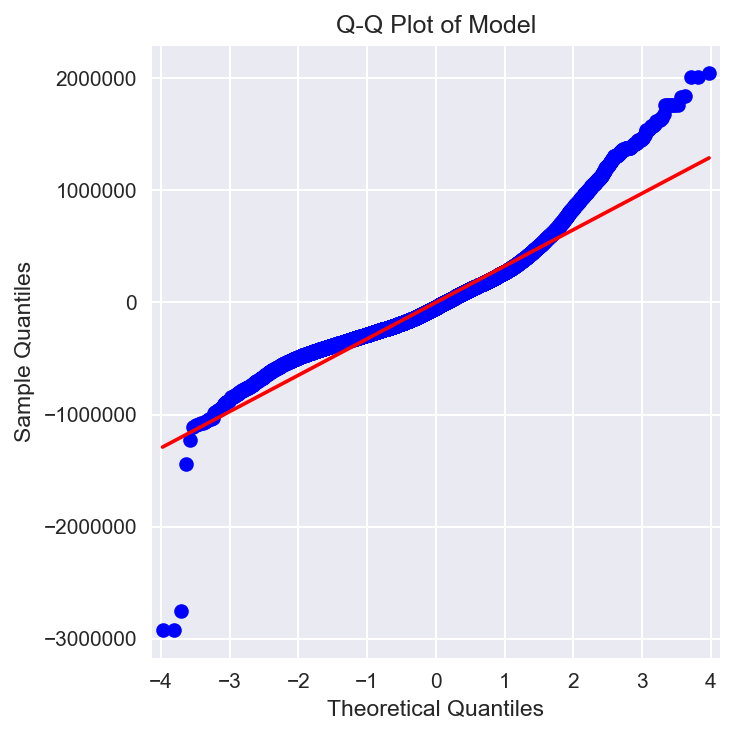

In [76]:
qqplot(model = base, save=True, filename = 'basemodel_qqplot.png')

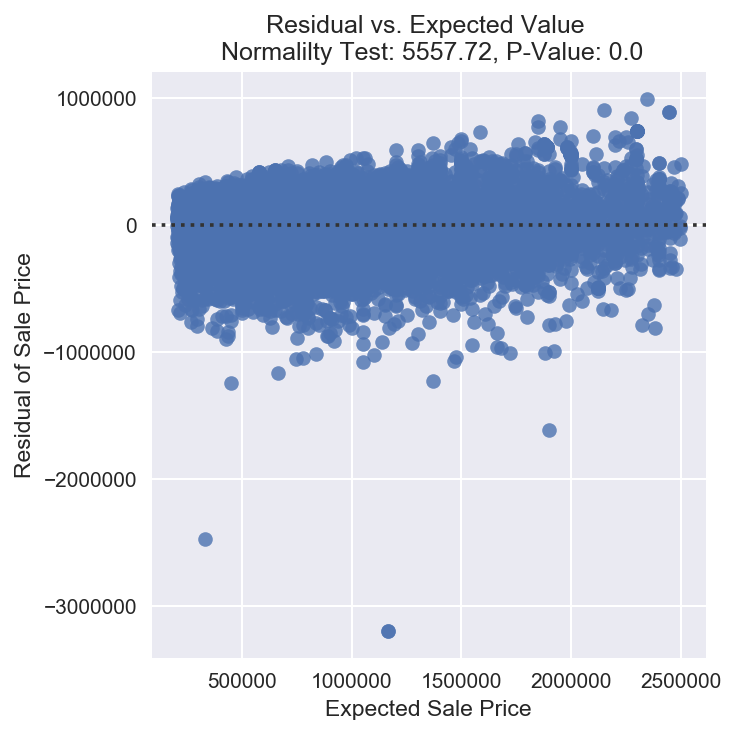

In [77]:
residplot(model=base, dep_var=base_dep, save=True, filename=('baseresidplot.png'))

/opt/anaconda3/envs/linreg-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


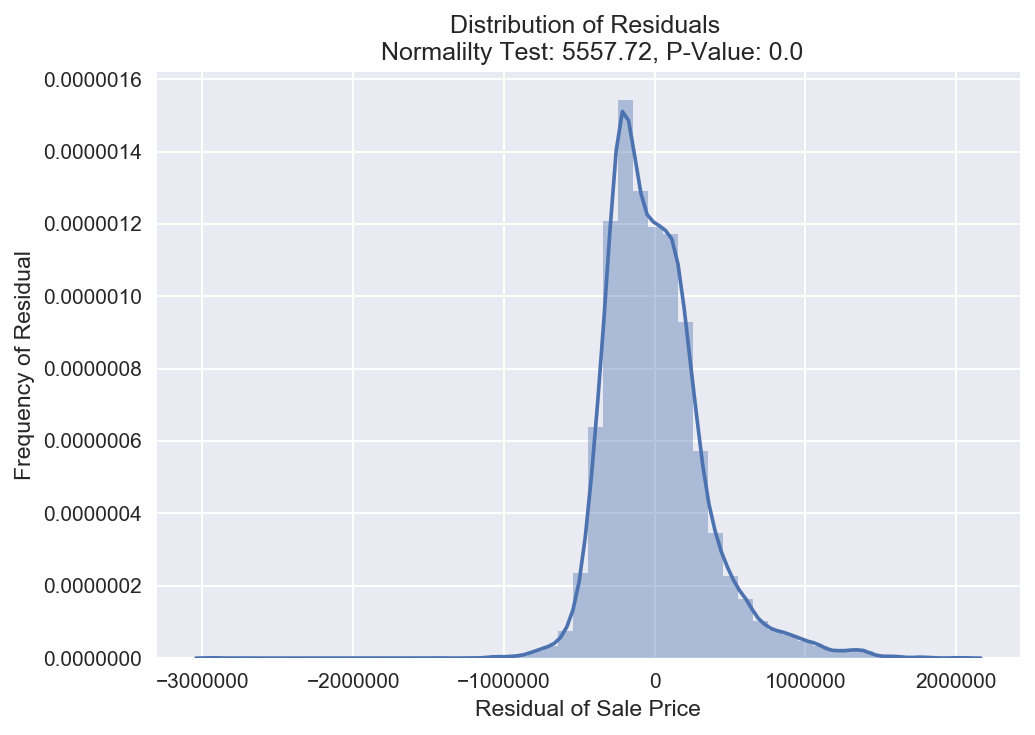

In [79]:
residdistplot(model = base, save=True, filename='basedistplot.png')

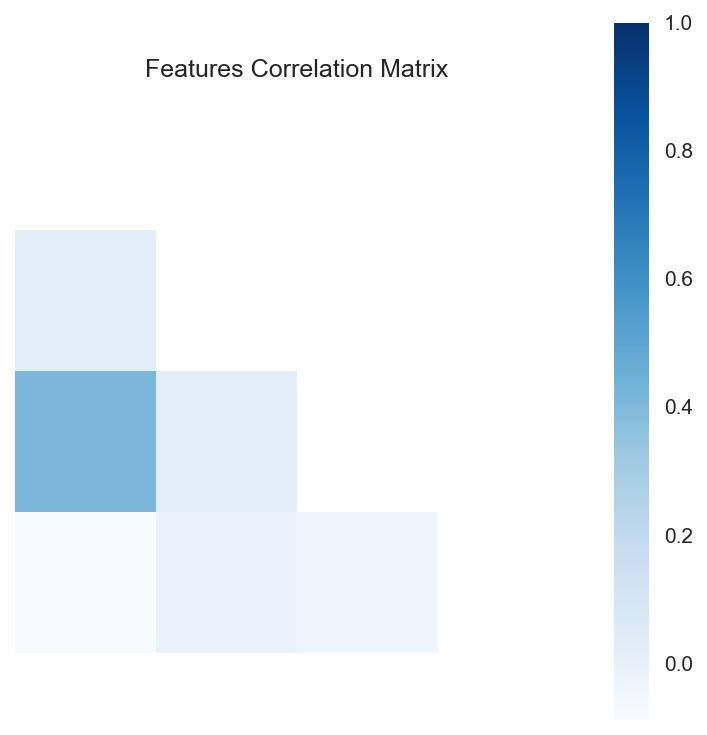

In [83]:
corrmatrixplot(features=base_features, save=True, filename=('basecorrmatrix.png'))